## Process Modeling Notation Thesis - Code user for Cluster Analysis
#### By: Andreia Guerreiro

In [1]:
#pip install --upgrade scikit-learn threadpoolctl --user

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from IPython.display import display
import warnings


# loat the date etc into df
file_path = # <Substitute with your file name>
df = pd.read_excel(file_path)

# Use the multiple-choice question: "Based on your experience, please select the 3 process modeling notations you use most frequently"
notation_col = "Process Notations you use the most"

# Drop rows with NaN in this column
notation_data = df[[notation_col]].dropna()

# Split the notations (comma-separated) into lists
notation_data["Notations_List"] = notation_data[notation_col].apply(lambda x: [i.strip() for i in x.split(",")])

# One-hot encode the notations
mlb = MultiLabelBinarizer()
notation_encoded = mlb.fit_transform(notation_data["Notations_List"])

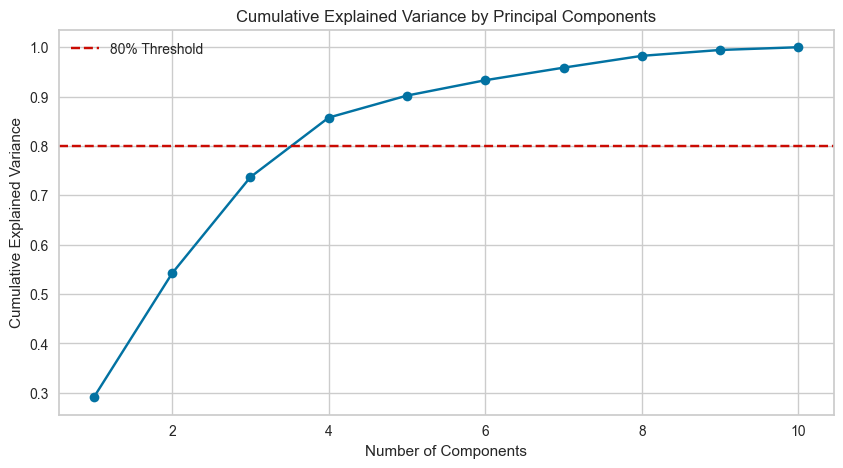

In [3]:
# Perform PCA
pca = PCA()
X_pca_full = pca.fit_transform(notation_encoded)

# Scree plot
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title("Cumulative Explained Variance by Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.legend()
plt.show()

C:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

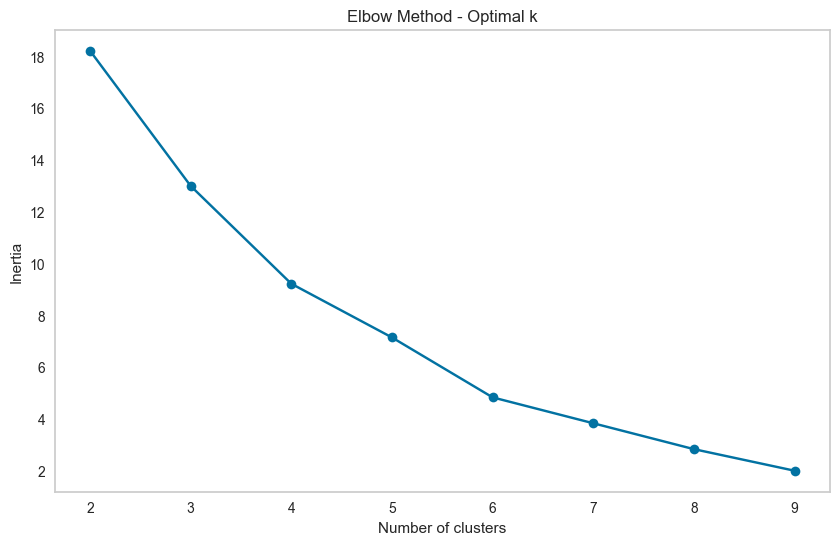

In [4]:
# 🔍 9. Determine Optimal Number of Clusters
# Elbow Method
inertia = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(notation_encoded)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method - Optimal k')
plt.grid()
plt.show()

In [5]:
# Cluster using KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(notation_encoded)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced = pca.fit_transform(notation_encoded)

# Create a DataFrame with PCA component loadings
feature_names = mlb.classes_
pca_components_df = pd.DataFrame(
    pca.components_.T,
    columns=["PCA1", "PCA2"],
    index=feature_names
).round(3)

# Display the PCA components
display(pca_components_df)

C:\Users\andre\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,PCA1,PCA2
ARCHIMATE,-0.162,0.024
BPMN (Business Process Model and Notation),-0.242,-0.135
CMMN (Case Management Model and Notation),-0.237,-0.475
DMN (Decision Model and Notation),-0.115,-0.146
EPC (Event-Driven Process Chain),-0.514,0.382
Flowcharts,0.461,0.516
Journey Map,0.001,0.051
PPT,0.089,0.120
Petri Nets,0.284,0.213
UML (Unified Modeling Language),0.530,-0.510


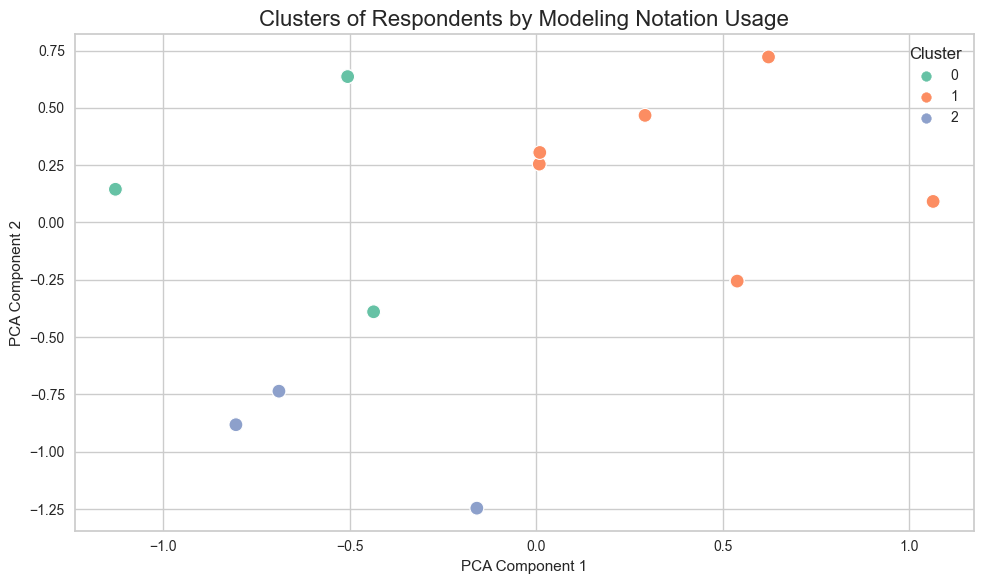

In [6]:
# Create a DataFrame for visualization
cluster_df = pd.DataFrame({
    "PCA1": reduced[:, 0],
    "PCA2": reduced[:, 1],
    "Cluster": clusters
})

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cluster_df, x="PCA1", y="PCA2", hue="Cluster", palette="Set2", s=100)
plt.title("Clusters of Respondents by Modeling Notation Usage", fontsize=16)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

C:\Users\andre\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:677: FutureWarning: The default value of `n_init` will change from 4 to 1 in 1.9.
  warnings.warn(


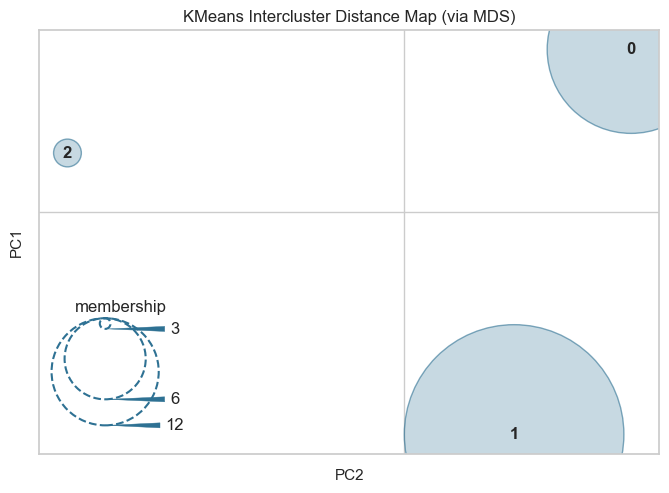

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [7]:
# Visualizing the clusters sizes and distances in 2D

visualizer = InterclusterDistance(kmeans)
visualizer.fit(cluster_df)
visualizer.show()

In [8]:
# Add the cluster labels to the original notation_data
notation_data_with_clusters = notation_data.copy()
notation_data_with_clusters["Cluster"] = clusters

# Also add the original roles and experience levels for profiling
notation_data_with_clusters["Role"] = df.loc[notation_data_with_clusters.index, 
    "What best describes your current role in relation to process modeling? "]
notation_data_with_clusters["Experience"] = df.loc[notation_data_with_clusters.index, 
    "Experience (Years)"]

# Flatten the notation usage per cluster
notation_data_with_clusters["Notations"] = notation_data_with_clusters["Notations_List"].apply(lambda lst: ", ".join(lst))

# Explode the list to count individual notation frequency per cluster
exploded = notation_data_with_clusters.explode("Notations_List")

# Group by cluster and notation
notation_freq_by_cluster = exploded.groupby(["Cluster", "Notations_List"]).size().unstack(fill_value=0)

# Group by cluster and role
role_freq_by_cluster = notation_data_with_clusters.groupby(["Cluster", "Role"]).size().unstack(fill_value=0)

# Group by cluster and experience
experience_by_cluster = notation_data_with_clusters.groupby(["Cluster", "Experience"]).size().unstack(fill_value=0)

# Display results
display(notation_freq_by_cluster)
display(role_freq_by_cluster)
display(experience_by_cluster)

Notations_List,ARCHIMATE,BPMN (Business Process Model and Notation),CMMN (Case Management Model and Notation),DMN (Decision Model and Notation),EPC (Event-Driven Process Chain),Flowcharts,Journey Map,PPT,Petri Nets,UML (Unified Modeling Language)
Cluster,,,,,,,,,,
0,1,6,0,0,6,4,0,0,0,1
1,0,10,0,0,0,12,1,1,3,7
2,0,3,3,1,0,0,0,0,0,1


Role,",",Academic / Researcher,Business Analyst,Business Operations Manager,Consultant,Enterprise Architect,Process Analyst,Software Engineer / Developer,service designer
Cluster,,,,,,,,,
0,0,0,1,1,0,3,0,1,0
1,0,1,2,0,2,3,2,1,1
2,1,0,0,0,1,0,0,1,0


Experience,1–2 years,3–5 years,6–10 years,Less than 1 year,More than 10 years
Cluster,,,,,
0,0,1,1,0,4
1,2,3,1,2,4
2,0,0,1,1,1
